In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

In [3]:
import yellowbrick as yb 
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)

from yellowbrick.features.rankd import Rank2D
from yellowbrick.features.radviz import RadViz
from yellowbrick.features.pcoords import ParallelCoordinates
from yellowbrick.features.scatter import ScatterViz


/usr/local/var/pyenv/versions/3.5.2/envs/yellowbrick/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
# import pandas as pd
# url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
# col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
# iris = pd.read_csv(url, header=None, names=col_names)
# iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

In [6]:
iris = datasets.load_iris()
feature_df = pd.DataFrame(iris.data[:, :], columns=iris.feature_names)
X = feature_df[['sepal length (cm)', 'sepal width (cm)']]
y = iris.target

In [7]:
X = X.as_matrix()
# y = y.as_matrix()

In [8]:
features = ['sepal length (cm)', 'sepal width (cm)',]
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

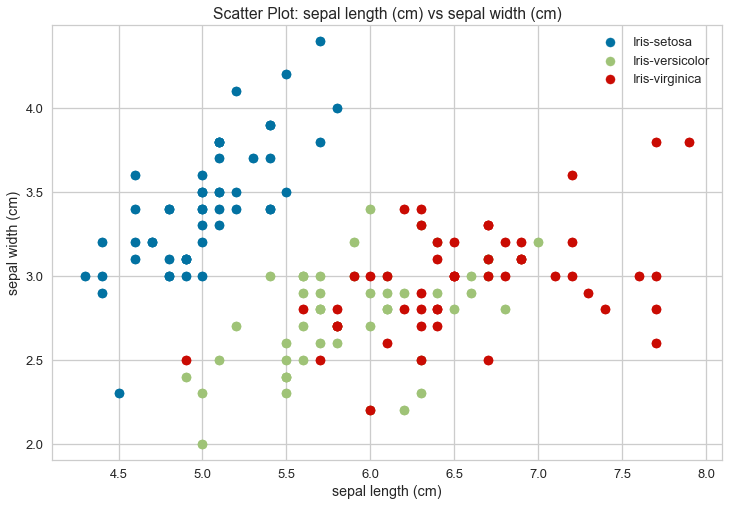

In [9]:
visualizer = ScatterViz(classes=classes, features=features)
visualizer.fit(X, y)      # Fit the data to the visualizer
visualizer.poof()         # Draw/show/poof the data

In [1]:
from yellowbrick.classifier import ClassificationScoreVisualizer

/usr/local/var/pyenv/versions/3.5.2/envs/yellowbrick/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support

from yellowbrick.exceptions import YellowbrickTypeError
from yellowbrick.utils import get_model_name, isestimator, isclassifier
from yellowbrick.base import Visualizer, ScoreVisualizer, MultiModelMixin
from yellowbrick.style.palettes import color_sequence, color_palette, LINE_COLOR

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from yellowbrick.features.base import DataVisualizer
from yellowbrick.utils import is_dataframe
from yellowbrick.exceptions import YellowbrickValueError
from yellowbrick.style.colors import resolve_colors, get_color_cycle

class ClusterReport(ClassificationScoreVisualizer):
    """
    ScatterVisualizer is a bivariate data visualization algorithm that plots
    using the Cartesian coordinates of each point.
    """

    def __init__(self, ax=None, features=None, classes=None, color=None,
                 colormap=None, **kwargs):
        """
        Initialize the base scatter with many of the options required in order
        to make the visualization work.

        Parameters
        ----------

        :param ax: the axis to plot the figure on.

        :param features: a list of feature names to use
            If a DataFrame is passed to fit and features is None, feature
            names are selected as the columns of the DataFrame.

        :param classes: a list of class names for the legend
            If classes is None and a y value is passed to fit then the classes
            are selected from the target vector.

        :param color: optional list or tuple of colors to colorize lines
            Use either color to colorize the lines on a per class basis or
            colormap to color them on a continuous scale.

        :param colormap: optional string or matplotlib cmap to colorize lines
            Use either color to colorize the lines on a per class basis or
            colormap to color them on a continuous scale.

        :param kwargs: keyword arguments passed to the super class.

        These parameters can be influenced later on in the visualization
        process, but can and should be set as early as possible.
        """
        super(ClusterReport, self).__init__(
            ax, features, classes, color, colormap, **kwargs
        )


    def fit(self, X, y=None, **kwargs):
        """
        The fit method is the primary drawing input for the parallel coords
        visualization since it has both the X and y data required for the
        viz and the transform method does not.

        Parameters
        ----------
        X : ndarray or DataFrame of shape n x m
            A matrix of n instances with m features

        y : ndarray or Series of length n
            An array or series of target or class values

        kwargs : dict
            Pass generic arguments to the drawing method

        Returns
        -------
        self : instance
            Returns the instance of the transformer/visualizer
        """
        nrows, ncols = X.shape

        # Store the classes for the legend if they're None.
        if self.classes_ is None:
            # TODO: Is this the most efficient method?
            self.classes_ = [str(label) for label in set(y)]

        # Handle the feature names if they're None.
        if self.features_ is None:
                # If X is a data frame, get the columns off it.
                if is_dataframe(X) and X.columns == 2:
                    self.features_ = X.columns

                # Otherwise create numeric labels for each column.
                elif ncols == 2:
                    self.features_ = [
                        str(cdx) for cdx in range(ncols)
                    ]
                else:
                    raise YellowbrickValueError('ScatterVisualizer only accepts two features, please explicted set the features key argument or only pass a matrix/ dataframe with only two columns')

        # Draw the instances
        self.draw(X, y, **kwargs)

        # Fit always returns self.
        return self

    def draw(self, X, y, **kwargs):
        """
        Called from the fit method, this method creates a scatter plot that draws
        each instance as a class or target colored point, whose location
        is determined by the feature data set.
        """
        # Get the shape of the data
        nrows, ncols = X.shape

        # Create the axes if they don't exist
        if self.ax is None:
                self.ax = plt.gca(xlim=[-1,1], ylim=[-1,1])

        color_values = get_color_cycle()
        colors = dict(zip(self.classes_, color_values))
        
        clf = neighbors.KNeighborsClassifier(15, weights='uniform')
        clf.fit(X, y)

        h = .02
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
        self.ax.pcolormesh(xx, yy, Z, cmap=cmap_bold)
        
        # Create a data structure to hold the scatter plot representations
        to_plot = {}
        for kls in self.classes_:
            to_plot[kls] = [[], []]

        # Add each row of the data set to to_plot for plotting
        # TODO: make this an independent function for override
        for i, row in enumerate(X):
            row_ = np.repeat(np.expand_dims(row, axis=1), 2, axis=1)
            x_, y_   = row_[0], row_[1]
            kls = self.classes_[y[i]]

            to_plot[kls][0].append(x_)
            to_plot[kls][1].append(y_)

        # Add the scatter plots from the to_plot function
        # TODO: store these plots to add more instances to later
        # TODO: make this a separate function
        for i, kls in enumerate(self.classes_):
            self.ax.scatter(to_plot[kls][0], to_plot[kls][1], color=colors[kls], label=str(kls), **kwargs)

        self.ax.axis('equal')

    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.

        """
        # Divide out the two features
        feature_one, feature_two = self.features_

        # Set the title
        self.set_title(
            'Scatter Plot: {0} vs {1}'.format(feature_one, feature_two)
        )
        # Add the legend
        self.ax.legend(loc='best')
        self.ax.set_xlabel(feature_one)
        self.ax.set_ylabel(feature_two)


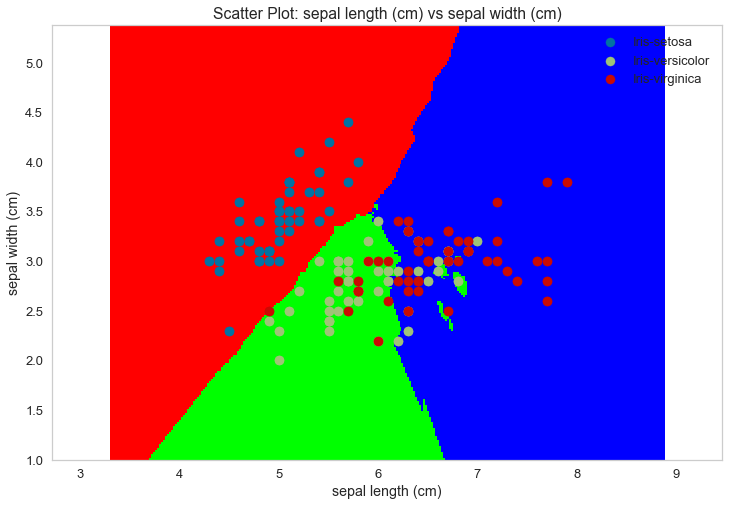

In [14]:
features = ['sepal length (cm)', 'sepal width (cm)',]
classes = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

knn_clf = neighbors.KNeighborsClassifier(15, weights='uniform')

report = ClusterReport(features=features, classes=classes)
report.fit(X, y)
report.poof()